In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt   
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression


In [2]:
def map_to_macrocategory(category):
    if category in ['BEVERAGES', 'BREAD/BAKERY', 'DAIRY', 'DELI', 'EGGS', 'FROZEN FOODS', 
                    'GROCERY I', 'GROCERY II', 'MEATS', 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SEAFOOD']:
        return 'Alimentos e Bebidas'
    elif category in ['BABY CARE', 'BEAUTY', 'PERSONAL CARE']:
        return 'Cuidados Pessoais e Saúde'
    elif category in ['CLEANING', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES', 
                      'HOME CARE', 'LAWN AND GARDEN']:
        return 'Casa e Jardim'
    elif category in ['LADIESWEAR', 'LINGERIE']:
        return 'Moda e Vestuário'
    elif category == 'AUTOMOTIVE':
        return 'Automotivo'
    elif category == 'PET SUPPLIES':
        return 'Animais de Estimação'
    elif category in ['BOOKS', 'MAGAZINES', 'CELEBRATION', 'PLAYERS AND ELECTRONICS', 'HARDWARE']:
        return 'Lazer, Tecnologia e Ferramentas'
    elif category == 'LIQUOR,WINE,BEER':
        return 'Bebidas Alcoólicas'
    elif category == 'SCHOOL AND OFFICE SUPPLIES':
        return 'Escola e Escritório'
    else:
        return 'Outros'

In [3]:
def adding_date(data):
    data['date']= pd.to_datetime(data['date'])
    data.set_index('date', inplace = True)
    full_date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
    data = data.reindex(full_date_range)
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'date'}, inplace=True)
    return data


In [4]:
def payday(date):
    if date.day == 15:
        return 1
    elif date == pd.Timestamp(date.year, date.month, 1) + pd.DateOffset(months=1) - pd.DateOffset(days=1):
        return 1
    else:
        return 0

In [5]:
def feriados(dados, holidays, stores):
    # Adicionando coluna 'holiday' com 0 inicialmente
    dados['holiday'] = 0
    holidays['transferred'] = holidays['transferred'].astype(bool)
    holidays['date']= pd.to_datetime(holidays['date'])
    # Merge de 'dados' com 'stores' para trazer 'city' e 'state'
    dados = dados.merge(stores[['store_nbr', 'city', 'state']], on='store_nbr', how='left')

    # Selecionando apenas colunas relevantes de 'holidays' para o merge
    holidays_relevant = holidays[['date', 'locale', 'locale_name', 'transferred']]

    # Merge de 'dados' com 'holidays' alinhando por 'date' e considerando as colunas relevantes
    dados = dados.merge(holidays_relevant, on='date', how='left', suffixes=('', '_hol'))
    dados['transferred'] = dados['transferred'].fillna(False)
    # Condições para definir 'holiday' com base em 'locale'
    dados.loc[(dados['locale'] == 'National') & ~dados['transferred'], 'holiday'] = 1
    dados.loc[(dados['locale'] == 'Regional') & (dados['locale_name'] == dados['state']) & ~dados['transferred'], 'holiday'] = 1
    dados.loc[(dados['locale'] == 'Local') & (dados['locale_name'] == dados['city']) & ~dados['transferred'], 'holiday'] = 1

    # Limpar colunas desnecessárias se necessário
    dados.drop(columns=['city', 'state', 'locale', 'locale_name', 'transferred'], errors='ignore', inplace=True)
    return dados

In [6]:
def RMSLE(y_pred, y_real):
    y_real = np.where(y_real <= 0, np.finfo(float).eps, y_real)
    y_pred = np.where(y_pred <= 0, np.finfo(float).eps, y_pred)
    log_real = np.log1p(y_real)
    log_pred = np.log1p(y_pred)
    mse_log = mean_squared_error(log_real, log_pred)
    rmsle_value = np.sqrt(mse_log)
    return rmsle_value

In [7]:
treino = pd.read_csv('Data/train.csv.gz', compression='gzip')
treino= treino.drop(columns=['id'])
treino['date']= pd.to_datetime(treino['date'])
stores = pd.read_csv('Data/stores.csv')
oil = pd.read_csv('Data/oil.csv')
holidays = pd.read_csv('Data/holidays_events.csv')

In [8]:
null_counts = oil.isnull().sum()
print(null_counts)

date           0
dcoilwtico    43
dtype: int64


In [9]:
#Adiciona datas faltantes no óleo
oil = adding_date(oil)

In [10]:
#preenche o primeiro valor como 95 (preço médio do mês)
oil.iloc[0] = oil.iloc[0].fillna(95)
#preenche com os valores do dia anterior 
oil =oil.ffill()

In [11]:
#junta os dados com o óleo
dados= pd.merge(treino, oil, on=['date'], how= 'left')

In [12]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   sales        float64       
 4   onpromotion  int64         
 5   dcoilwtico   float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 137.4+ MB


In [13]:
#Verifica quantos valores únicoas existem na coluna family
dados["family"].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [14]:
#Verifica os valores nulos
null_counts = dados.isnull().sum()
print(null_counts)

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dcoilwtico     0
dtype: int64


In [15]:
dados = feriados(dados, holidays, stores)
"""# Adicionando coluna 'holiday' com 0 inicialmente
dados['holiday'] = 0
holidays['transferred'] = holidays['transferred'].astype(bool)
holidays['date']= pd.to_datetime(holidays['date'])
# Merge de 'dados' com 'stores' para trazer 'city' e 'state'
dados = dados.merge(stores[['store_nbr', 'city', 'state']], on='store_nbr', how='left')

# Selecionando apenas colunas relevantes de 'holidays' para o merge
holidays_relevant = holidays[['date', 'locale', 'locale_name', 'transferred']]

# Merge de 'dados' com 'holidays' alinhando por 'date' e considerando as colunas relevantes
dados = dados.merge(holidays_relevant, on='date', how='left', suffixes=('', '_hol'))
dados['transferred'] = dados['transferred'].fillna(False)
# Condições para definir 'holiday' com base em 'locale'
dados.loc[(dados['locale'] == 'National') & ~dados['transferred'], 'holiday'] = 1
dados.loc[(dados['locale'] == 'Regional') & (dados['locale_name'] == dados['state']) & ~dados['transferred'], 'holiday'] = 1
dados.loc[(dados['locale'] == 'Local') & (dados['locale_name'] == dados['city']) & ~dados['transferred'], 'holiday'] = 1

# Limpar colunas desnecessárias se necessário
dados.drop(columns=['city', 'state', 'locale', 'locale_name', 'transferred'], errors='ignore', inplace=True)"""

"# Adicionando coluna 'holiday' com 0 inicialmente\ndados['holiday'] = 0\nholidays['transferred'] = holidays['transferred'].astype(bool)\nholidays['date']= pd.to_datetime(holidays['date'])\n# Merge de 'dados' com 'stores' para trazer 'city' e 'state'\ndados = dados.merge(stores[['store_nbr', 'city', 'state']], on='store_nbr', how='left')\n\n# Selecionando apenas colunas relevantes de 'holidays' para o merge\nholidays_relevant = holidays[['date', 'locale', 'locale_name', 'transferred']]\n\n# Merge de 'dados' com 'holidays' alinhando por 'date' e considerando as colunas relevantes\ndados = dados.merge(holidays_relevant, on='date', how='left', suffixes=('', '_hol'))\ndados['transferred'] = dados['transferred'].fillna(False)\n# Condições para definir 'holiday' com base em 'locale'\ndados.loc[(dados['locale'] == 'National') & ~dados['transferred'], 'holiday'] = 1\ndados.loc[(dados['locale'] == 'Regional') & (dados['locale_name'] == dados['state']) & ~dados['transferred'], 'holiday'] = 1\nda

In [16]:
dados.dtypes

date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dcoilwtico            float64
holiday                 int64
dtype: object

In [17]:
print(dados.describe())

                                date     store_nbr         sales  \
count                        3054348  3.054348e+06  3.054348e+06   
mean   2015-04-26 12:11:45.717619200  2.750000e+01  3.590209e+02   
min              2013-01-01 00:00:00  1.000000e+00  0.000000e+00   
25%              2014-03-01 00:00:00  1.400000e+01  0.000000e+00   
50%              2015-04-28 12:00:00  2.750000e+01  1.100000e+01   
75%              2016-06-22 00:00:00  4.100000e+01  1.960110e+02   
max              2017-08-15 00:00:00  5.400000e+01  1.247170e+05   
std                              NaN  1.558579e+01  1.107286e+03   

        onpromotion    dcoilwtico       holiday  
count  3.054348e+06  3.054348e+06  3.054348e+06  
mean   2.617480e+00  6.786101e+01  8.599118e-02  
min    0.000000e+00  2.619000e+01  0.000000e+00  
25%    0.000000e+00  4.632000e+01  0.000000e+00  
50%    0.000000e+00  5.341000e+01  0.000000e+00  
75%    0.000000e+00  9.572000e+01  0.000000e+00  
max    7.410000e+02  1.106200e+02  1.

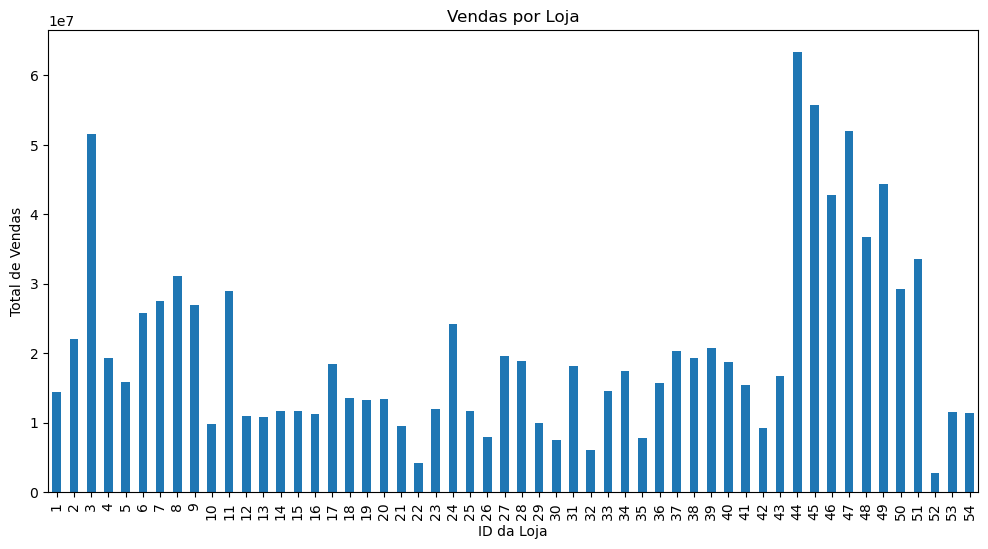

In [18]:
vendas_por_loja = dados.groupby('store_nbr')['sales'].sum()
plt.figure(figsize=(12, 6))
vendas_por_loja.plot(kind='bar')
plt.title('Vendas por Loja')
plt.xlabel('ID da Loja')
plt.ylabel('Total de Vendas')
plt.xticks(rotation=90)
plt.show()

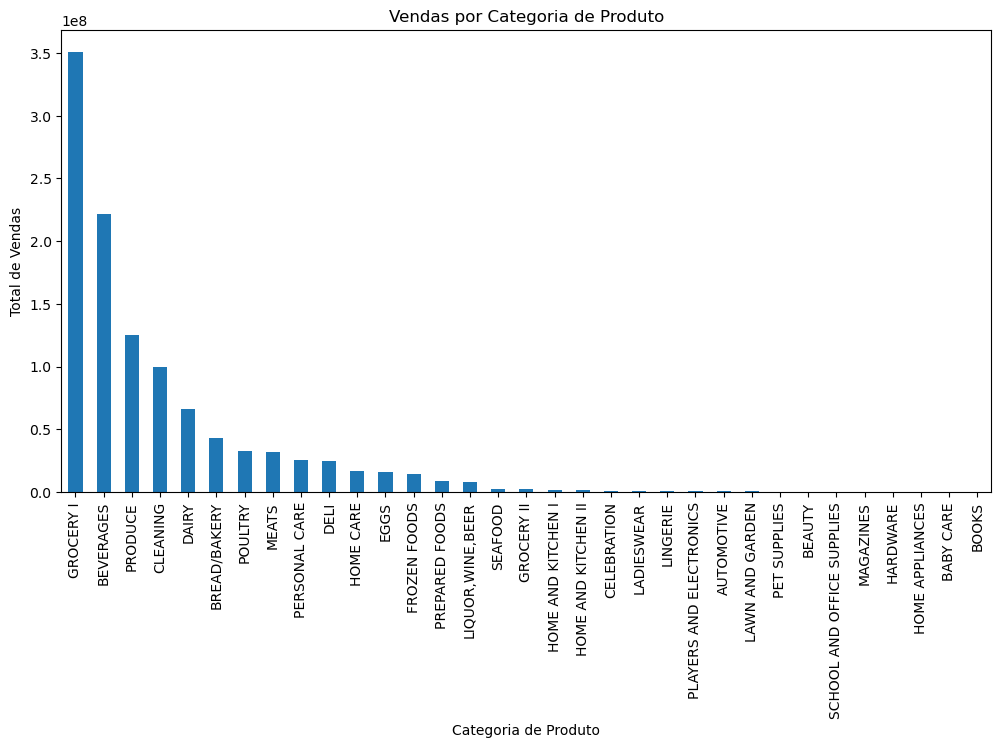

In [19]:
vendas_por_categoria = dados.groupby('family')['sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
vendas_por_categoria.plot(kind='bar')
plt.title('Vendas por Categoria de Produto')
plt.xlabel('Categoria de Produto')
plt.ylabel('Total de Vendas')
plt.xticks(rotation=90)
plt.show()

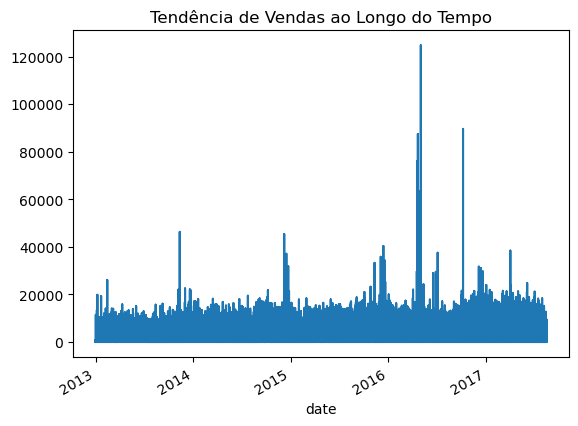

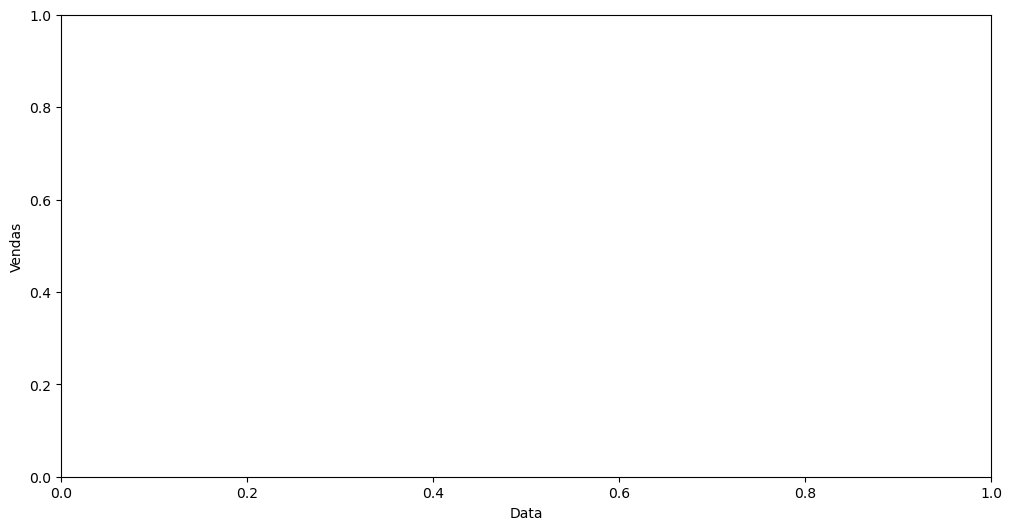

In [20]:
dados.set_index('date')['sales'].plot()
plt.title('Tendência de Vendas ao Longo do Tempo')
plt.figure(figsize=(12, 6))
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.show()

In [21]:
"""categorias = dados['family'].unique()
dados.set_index('date', inplace=True)
for categoria in categorias:
    plt.figure(figsize=(12, 6))
    vendas_categoria = dados[dados['family'] == categoria]['sales']
    vendas_categoria.groupby(vendas_categoria.index.year).sum().plot()
    plt.title(f'Tendência de Vendas Anuais para {categoria}')
    plt.xlabel('Ano')
    plt.ylabel('Vendas')
    plt.show()
"""

"categorias = dados['family'].unique()\ndados.set_index('date', inplace=True)\nfor categoria in categorias:\n    plt.figure(figsize=(12, 6))\n    vendas_categoria = dados[dados['family'] == categoria]['sales']\n    vendas_categoria.groupby(vendas_categoria.index.year).sum().plot()\n    plt.title(f'Tendência de Vendas Anuais para {categoria}')\n    plt.xlabel('Ano')\n    plt.ylabel('Vendas')\n    plt.show()\n"

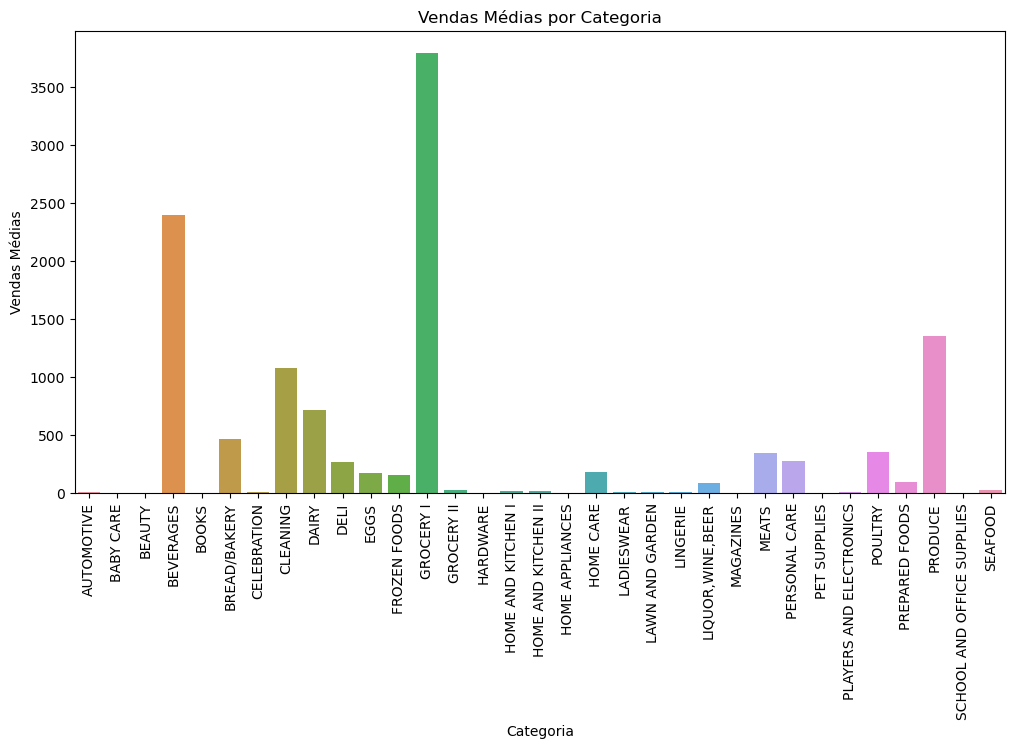

In [22]:
category_means = dados.groupby('family')['sales'].mean().reset_index()

# Plotando o gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x='family', y='sales', data=category_means)
plt.xticks(rotation=90)
plt.title('Vendas Médias por Categoria')
plt.xlabel('Categoria')
plt.ylabel('Vendas Médias')
plt.show()

In [23]:
dados.reset_index(inplace=True)

In [24]:
dados = dados.merge(stores[['store_nbr', 'cluster', 'type']], on='store_nbr', how='left')

In [25]:
null_counts = dados.isnull().sum()
print(null_counts)

index          0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dcoilwtico     0
holiday        0
cluster        0
type           0
dtype: int64


In [26]:
dados['category'] = dados['family'].apply(map_to_macrocategory)

In [27]:
dados.dtypes

index                   int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dcoilwtico            float64
holiday                 int64
cluster                 int64
type                   object
category               object
dtype: object

In [28]:
dados['dia_da_semana'] = dados['date'].dt.dayofweek  
dados['dia_do_mes'] = dados['date'].dt.day      
dados['dia_do_ano'] = dados['date'].dt.dayofyear

In [29]:
dados.head()

,index,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday,cluster,type,category,dia_da_semana,dia_do_mes,dia_do_ano
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,95.0,1,13,D,Automotivo,1,1,1
1,1,2013-01-01,1,BABY CARE,0.0,0,95.0,1,13,D,Cuidados Pessoais e Saúde,1,1,1
2,2,2013-01-01,1,BEAUTY,0.0,0,95.0,1,13,D,Cuidados Pessoais e Saúde,1,1,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,95.0,1,13,D,Alimentos e Bebidas,1,1,1
4,4,2013-01-01,1,BOOKS,0.0,0,95.0,1,13,D,"Lazer, Tecnologia e Ferramentas",1,1,1


In [30]:
dados["dia_de_pagamento"] = dados["date"].apply(payday)

In [ ]:
dados.to_csv('dados_compactados.csv.gz', compression='gzip', index=False)

In [ ]:
dados.head()

,index,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday,cluster,type,category,dia_da_semana,dia_do_mes,dia_do_ano,dia_de_pagamento
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,95.0,1,13,D,Automotivo,1,1,1,0
1,1,2013-01-01,1,BABY CARE,0.0,0,95.0,1,13,D,Cuidados Pessoais e Saúde,1,1,1,0
2,2,2013-01-01,1,BEAUTY,0.0,0,95.0,1,13,D,Cuidados Pessoais e Saúde,1,1,1,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,95.0,1,13,D,Alimentos e Bebidas,1,1,1,0
4,4,2013-01-01,1,BOOKS,0.0,0,95.0,1,13,D,"Lazer, Tecnologia e Ferramentas",1,1,1,0


In [ ]:
dados_encoded = pd.get_dummies(dados, columns=['category', 'type'])

In [ ]:
dados_encoded.drop(columns=['date', 'family', 'category', 'type', 'index'], errors='ignore', inplace=True)

In [ ]:
dados_encoded.head()

,store_nbr,sales,onpromotion,dcoilwtico,holiday,cluster,dia_da_semana,dia_do_mes,dia_do_ano,dia_de_pagamento,...,category_Casa e Jardim,category_Cuidados Pessoais e Saúde,category_Escola e Escritório,"category_Lazer, Tecnologia e Ferramentas",category_Moda e Vestuário,type_A,type_B,type_C,type_D,type_E
0,1,0.0,0,95.0,1,13,1,1,1,0,...,False,False,False,False,False,False,False,False,True,False
1,1,0.0,0,95.0,1,13,1,1,1,0,...,False,True,False,False,False,False,False,False,True,False
2,1,0.0,0,95.0,1,13,1,1,1,0,...,False,True,False,False,False,False,False,False,True,False
3,1,0.0,0,95.0,1,13,1,1,1,0,...,False,False,False,False,False,False,False,False,True,False
4,1,0.0,0,95.0,1,13,1,1,1,0,...,False,False,False,True,False,False,False,False,True,False


In [ ]:
len(dados_encoded.columns)

24

In [ ]:
dados_encoded.dtypes

store_nbr                                     int64
sales                                       float64
onpromotion                                   int64
dcoilwtico                                  float64
holiday                                       int64
cluster                                       int64
dia_da_semana                                 int32
dia_do_mes                                    int32
dia_do_ano                                    int32
dia_de_pagamento                              int64
category_Alimentos e Bebidas                   bool
category_Animais de Estimação                  bool
category_Automotivo                            bool
category_Bebidas Alcoólicas                    bool
category_Casa e Jardim                         bool
category_Cuidados Pessoais e Saúde             bool
category_Escola e Escritório                   bool
category_Lazer, Tecnologia e Ferramentas       bool
category_Moda e Vestuário                      bool
type_A      

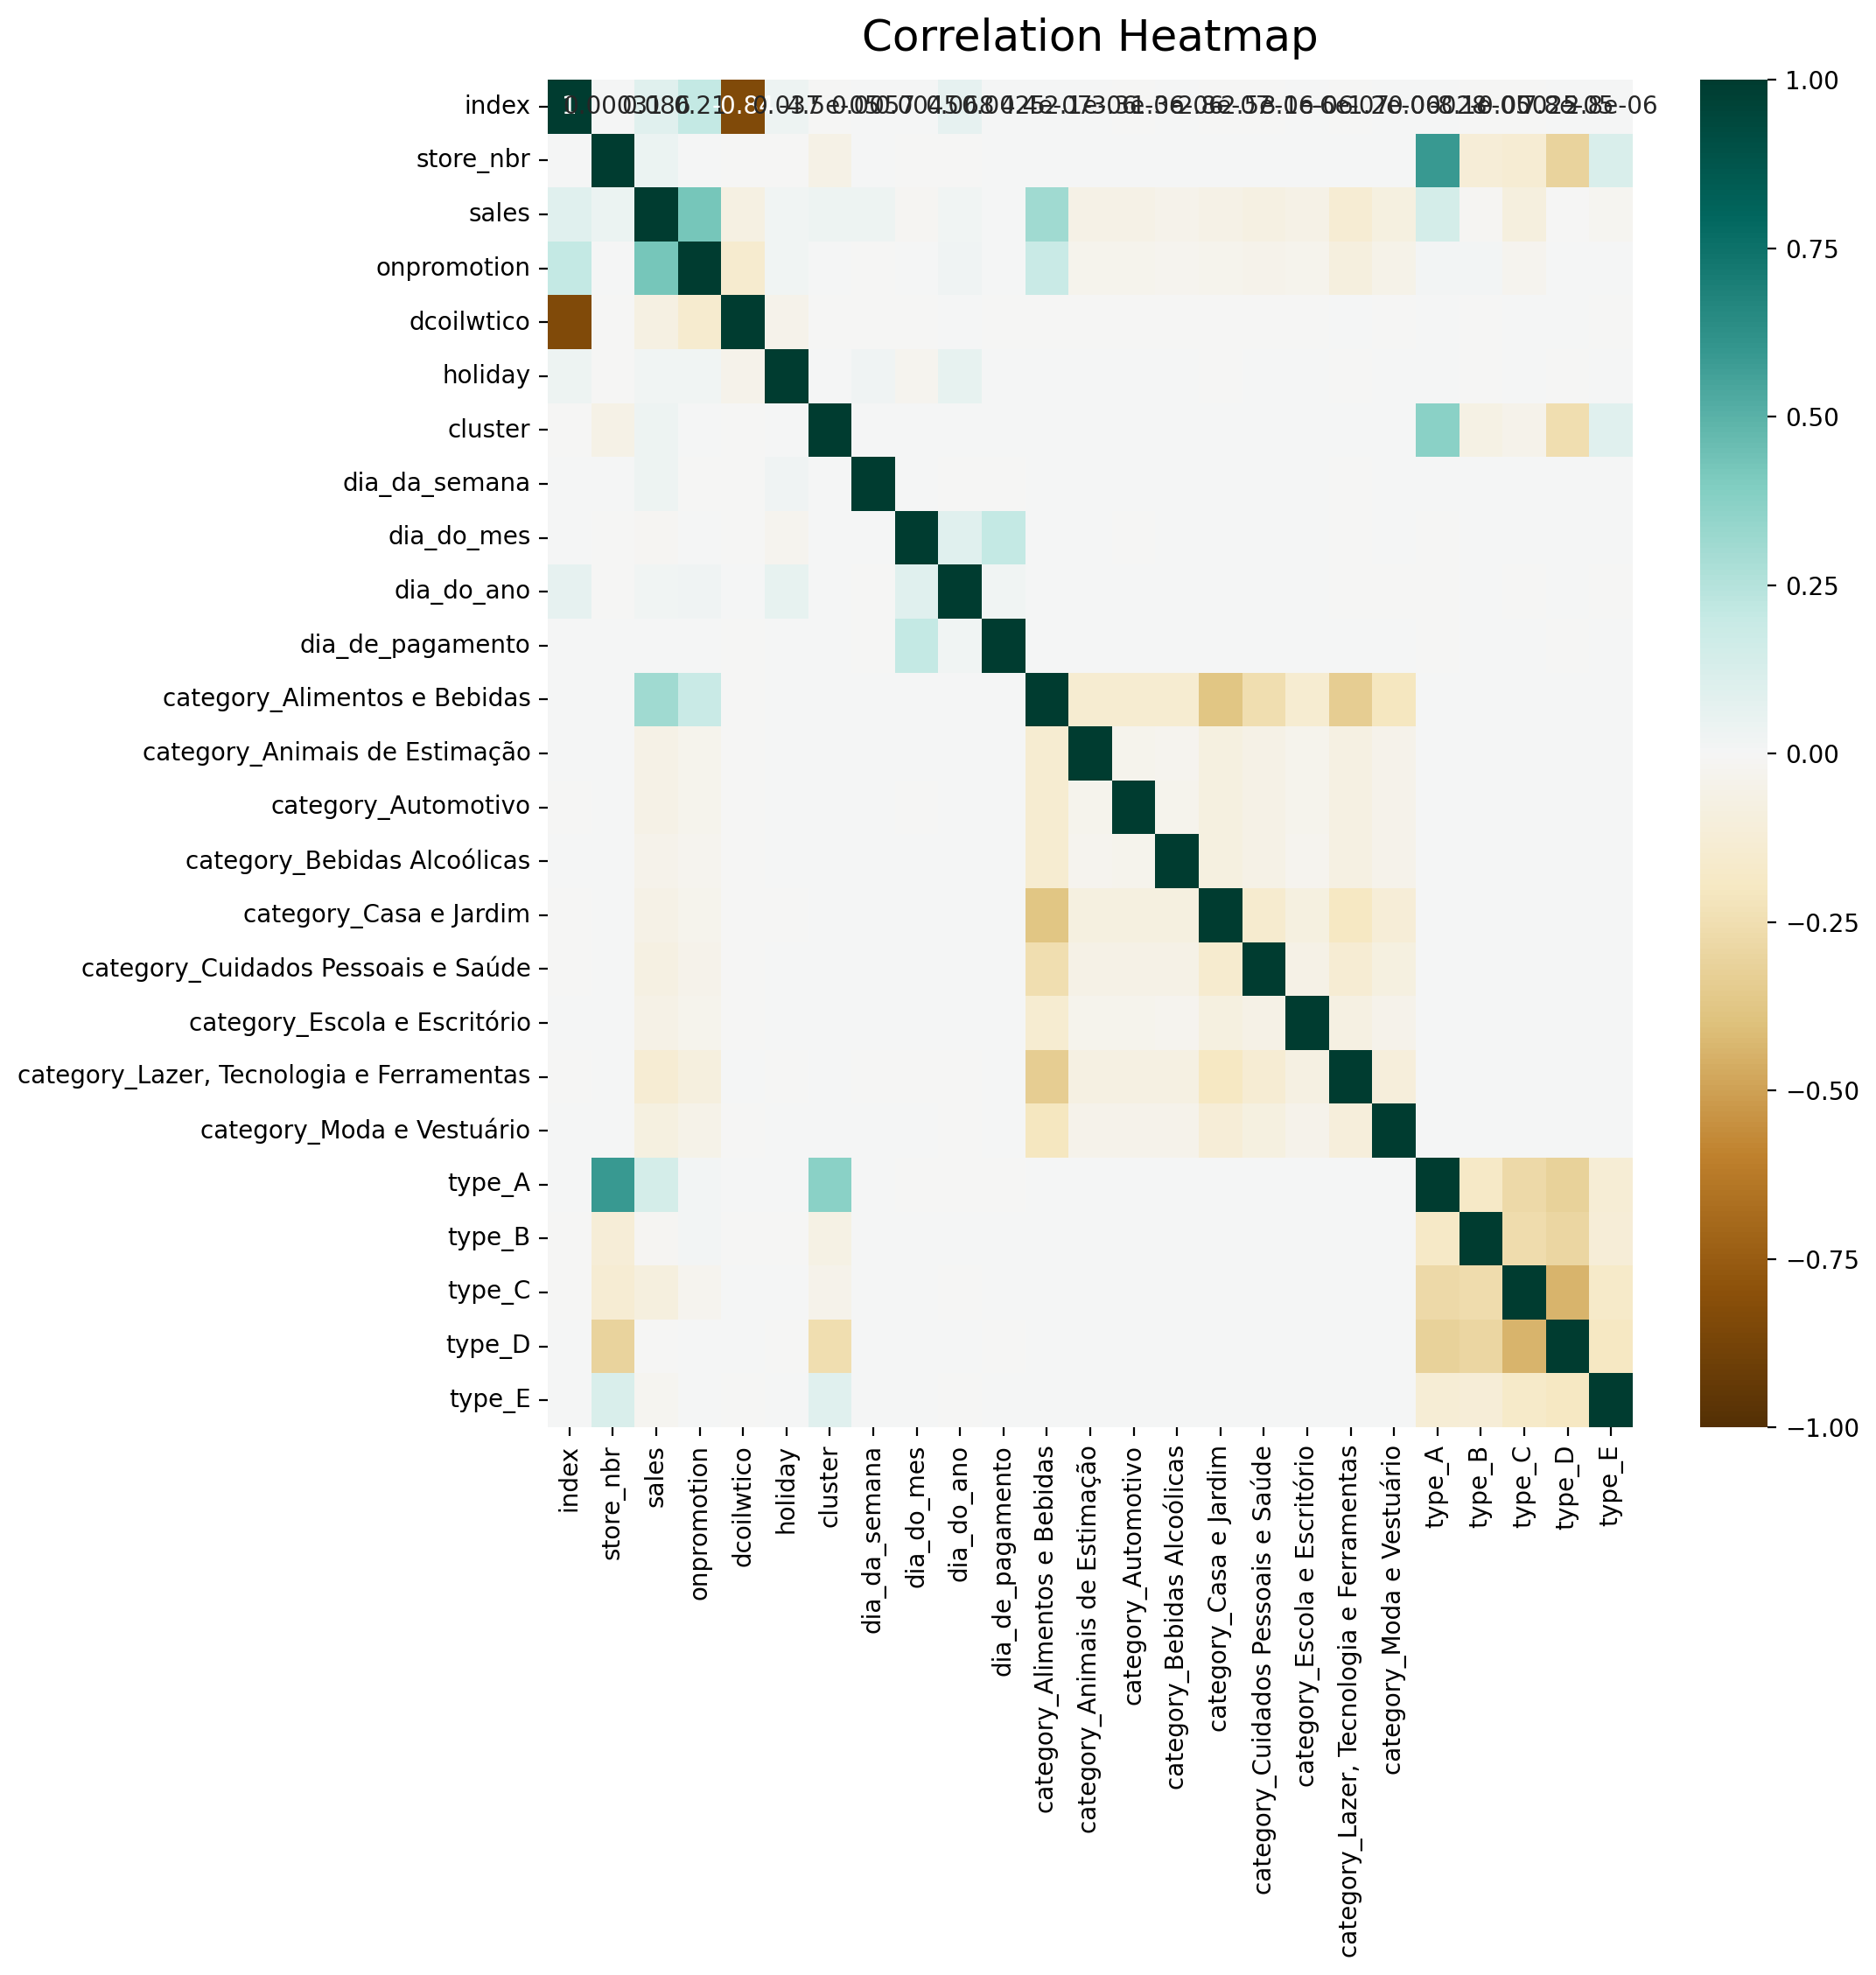

In [ ]:
plt.figure(figsize=(10, 10), dpi=200)
heatmap = sns.heatmap(dados_encoded.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG', annot_kws={"size": 10})
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

In [ ]:
label = dados_encoded['sales']
dados_encoded.drop(columns=['sales'], inplace=True)

In [ ]:
X_treino, X_teste, y_treino, y_teste = train_test_split(dados_encoded, label, test_size=0.2, shuffle=False)

In [ ]:
X_treino.columns

Index(['store_nbr', 'onpromotion', 'dcoilwtico', 'holiday', 'cluster',
       'dia_da_semana', 'dia_do_mes', 'dia_do_ano', 'dia_de_pagamento',
       'category_Alimentos e Bebidas', 'category_Animais de Estimação',
       'category_Automotivo', 'category_Bebidas Alcoólicas',
       'category_Casa e Jardim', 'category_Cuidados Pessoais e Saúde',
       'category_Escola e Escritório',
       'category_Lazer, Tecnologia e Ferramentas', 'category_Moda e Vestuário',
       'type_A', 'type_B', 'type_C', 'type_D', 'type_E'],
      dtype='object')

In [ ]:
scaler = StandardScaler()
X_treino = scaler.fit_transform(X_treino)
X_teste = scaler.fit_transform(X_teste)
#data_val = scaler.fit_transform(data_val)

In [ ]:
#Testando a quantidade de componentes do PCA utilizando a Variância explicada
pca_train = PCA()
pca_test = PCA()
#pca_val = PCA()

pca_train.fit(X_treino)
pca_test.fit(X_teste)
#pca_val.fit(data_val)

variancia_train = np.cumsum(pca_train.explained_variance_ratio_)
variancia_test = np.cumsum(pca_test.explained_variance_ratio_)
#variancia_val = np.cumsum(pca_val.explained_variance_ratio_)

In [ ]:
#Define quantas componentes acumuladas conseguem atingir determinado grau de variância
limiar_variancia = 0.8
n_components_train = np.where(variancia_train >= limiar_variancia)[0][0] + 1
n_components_test = np.where(variancia_test >= limiar_variancia)[0][0] + 1
#n_components_val = np.where(variancia_val >= limiar_variancia)[0][0] + 1

print(n_components_test)
print(n_components_train)
#print(n_components_val)

15
16


In [ ]:
if (n_components_test !=  n_components_train):
    n_components_test = max(n_components_test, n_components_train)
    n_components_train = max(n_components_test, n_components_train)
pca_train = PCA(n_components=n_components_train)
pca_test = PCA(n_components=n_components_test)
#pca_val = PCA(n_components=n_components_val)
X_pca_teste = pca_test.fit_transform(X_teste)
X_pca_treino = pca_train.fit_transform(X_treino)
#X_pca_val = pca_train.fit_transform(data_val)

In [ ]:
model_pca = LinearRegression()
model_pca.fit(X_pca_treino, y_treino)
y_pred_pca = model_pca.predict(X_pca_teste)

In [ ]:
resul = RMSLE(y_pred_pca, y_teste)
print(f"MSE for PCA: {resul}")

MSE for PCA: 2.61120884668356


In [ ]:
RMSLE_scorer = make_scorer(RMSLE, greater_is_better=False)

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

In [ ]:
tscv = TimeSeriesSplit(n_splits=3)

In [ ]:
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=tscv,
                           scoring=RMSLE_scorer,
                           verbose=2,
                           n_jobs=-1)

In [ ]:
grid_search.fit(X_pca_treino, y_treino)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


/home/savio/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/savio/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/savio/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=11.2min


/home/savio/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=22.8min


/home/savio/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=26.0min


/home/savio/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=33.2min


/home/savio/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [ ]:
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor pontuação (RMSLE):", grid_search.best_score_)

In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_pca_teste)

In [ ]:
rmsle_test = RMSLE(y_pred, y_teste)
print("RMSLE no conjunto de teste:", rmsle_test)